In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time


In [2]:
# load the training data
transform = torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
                                          ])

train_ds = torchvision.datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_ds = torchvision.datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)

In [3]:
print(len(train_ds))
print(len(test_ds))

60000
10000


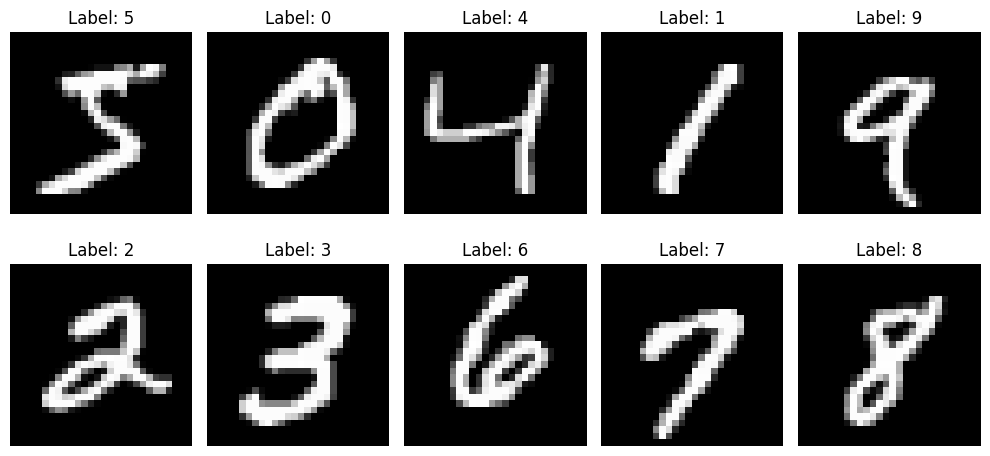

In [4]:
# Create a dictionary to store one image per label
images_per_label = {}

# Loop through the dataset to find one image per label
for img, label in train_ds:
    if label not in images_per_label:
        images_per_label[label] = img
    if len(images_per_label) == 10:  # Break the loop once we have all labels
        break

# Plot the images, one per label
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, (label, img) in enumerate(images_per_label.items()):
    ax = axes[i // 5, i % 5]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Hyperparameters
lr = 0.01
batch_size = 64
num_epoch = 10
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [6]:
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:3


In [7]:
# keep original before truncating
full_train = list(train_ds)

train_ds  = full_train[:10000]
valid_ds  = full_train[10000:12000]
test_ds   = list(test_ds)[:2000]

train_loader = torch.utils.data.DataLoader(train_ds, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(valid_ds, 
                                           batch_size=batch_size, 
                                           shuffle=False, 
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(test_ds, 
                                          batch_size=batch_size, 
                                          shuffle=False, 
                                          num_workers=2)

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, input_size=(28, 28)):
        super(MyCNN, self).__init__()

        # ---- Convolution layers ----
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3)  # conv1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)           # conv2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)           # conv3
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=2)          # conv4
        self.pool = nn.MaxPool2d(2)                              # maxpool for all layers

        # ---- Compute flatten size dynamically ----
        dummy_input = torch.zeros(1, in_channels, input_size[0], input_size[1])
        dummy_out = self._forward_features(dummy_input)
        flatten_dim = dummy_out.view(1, -1).size(1)

        # ---- Fully connected layer ----
        self.fc1 = nn.Linear(flatten_dim, num_classes)

    def _forward_features(self, x):
        """Passes input through conv + pool layers only."""
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return x

    def forward(self, x):
        # ---- Feature extraction ----
        x = self._forward_features(x)

        # ---- Flatten ----
        x = torch.flatten(x, 1)

        # ---- Fully connected ----
        logits = self.fc1(x)

        # Return logits and log softmax
        return logits, F.log_softmax(logits, dim=1)

In [43]:
cnn_model = MyCNN()
cnn_model = cnn_model.to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [44]:
print(cnn_model)

MyCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=10, bias=True)
)


In [45]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(train_loader=train_loader):
    cnn_model.train()                                      # sets model to training mode (dropout and batchnorm behaves in this mode)
    train_corr, train_total, train_running_loss = 0, 0, 0  # counters for tracting trainning accuracy, total examples, running loss

    for step, (data, y) in enumerate(train_loader):        # loops over batch of data in train_loader
        data, y = data.to(device), y.to(device)
        optimizer.zero_grad()                                # resets gradients to prevent accumulation
        _, logits = cnn_model(data)                          # gets the logits 
        loss = loss_fn(logits, y)                            # calculates loss comparing with true label
        loss.backward()                                      # back propagation is performed to compute gradients
        optimizer.step()                                     # optimizer updates model params

        y_pred = torch.argmax(logits, 1)                     # selects the predicted class (the index with the highest value)
        train_corr += torch.sum(torch.eq(y_pred, y).float()).item()      # counts correct predictions
        train_total += len(data)                             # tracks total no. of samples
        train_running_loss += loss.item()                    # accumulates loss
    
    # Calculate average loss and accuracy for this epoch
    epoch_loss = train_running_loss / len(train_loader)
    epoch_accuracy = train_corr / train_total

    # Append to lists for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}] Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
####################################################################################################################
   
def test(test_loader=test_loader):
    cnn_model.eval()                                        # sets model to evalutaion mode
    test_corr, test_total, test_running_loss = 0, 0, 0
    with torch.no_grad():
        for step, (data, y) in enumerate(test_loader):
            data, y = data.to(device), y.to(device)
            _, logits = cnn_model(data)
            loss = loss_fn(logits, y)
            y_pred = torch.argmax(logits, 1)
            test_corr += torch.sum(torch.eq(y_pred, y).float()).item()
            test_total += len(data)
            test_running_loss += loss.item()
    # Calculate average loss and accuracy for this epoch
    epoch_loss = test_running_loss / len(test_loader)
    epoch_accuracy = test_corr / test_total

    # Append to lists for plotting
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}] Valid/Test Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

In [46]:
for epoch in range(num_epoch):
  print(f"--------- Train EPOCH {epoch} -------------")
  train(train_loader)
  print(f"--------- Valid EPOCH {epoch} -------------")
  test(valid_loader)

--------- Train EPOCH 0 -------------
Epoch [1] Train Loss: 2.2645, Accuracy: 0.3146
--------- Valid EPOCH 0 -------------
Epoch [1] Valid/Test Loss: 2.1857, Accuracy: 0.5205
--------- Train EPOCH 1 -------------
Epoch [2] Train Loss: 1.5038, Accuracy: 0.6387
--------- Valid EPOCH 1 -------------
Epoch [2] Valid/Test Loss: 1.2671, Accuracy: 0.5460
--------- Train EPOCH 2 -------------
Epoch [3] Train Loss: 0.5658, Accuracy: 0.8214
--------- Valid EPOCH 2 -------------
Epoch [3] Valid/Test Loss: 0.6903, Accuracy: 0.7605
--------- Train EPOCH 3 -------------
Epoch [4] Train Loss: 0.4080, Accuracy: 0.8734
--------- Valid EPOCH 3 -------------
Epoch [4] Valid/Test Loss: 0.3930, Accuracy: 0.8710
--------- Train EPOCH 4 -------------
Epoch [5] Train Loss: 0.3367, Accuracy: 0.8982
--------- Valid EPOCH 4 -------------
Epoch [5] Valid/Test Loss: 0.3479, Accuracy: 0.8975
--------- Train EPOCH 5 -------------
Epoch [6] Train Loss: 0.2827, Accuracy: 0.9175
--------- Valid EPOCH 5 -------------
Ep

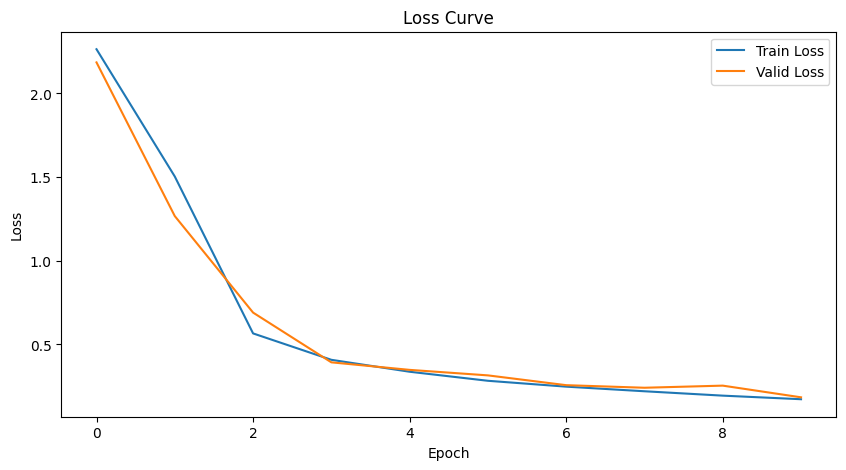

In [47]:
# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Valid Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

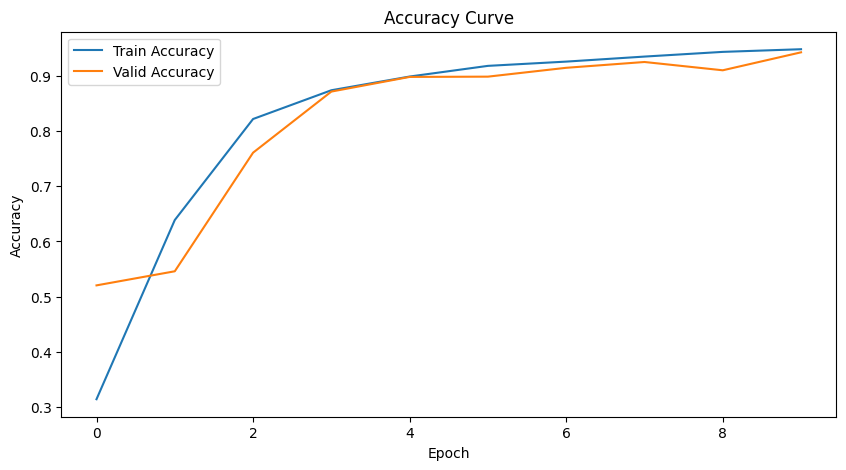

In [48]:
# Plot the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Valid Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

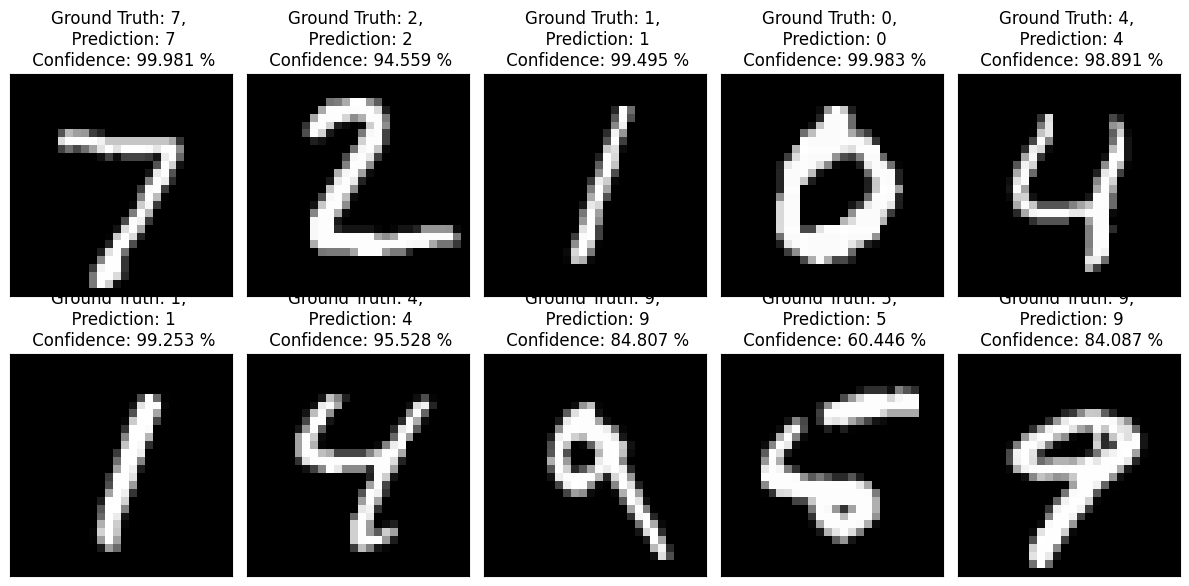

In [49]:
cnn_model.eval()
data, y = next(iter(test_loader))

# 1. push the data to the selected device
data, y = data.to(device), y.to(device)

# 2. feed the data into the model and the model makes predictions
_, logits = cnn_model(data)   # raw prediction before applying softmax ; unnormalised scores for each class

# 3. get the class with highest prob.
y_pred = torch.argmax(logits, 1) # finds the index of the class with the highest value (i.e., the predicted class) along dimension 1,

get_prob = torch.nn.Softmax(dim=1) # converts logits into probabilities that sums to 1
prob = get_prob(logits)            # prob is a tensor where each row corresponds to a sample, and each column contains the probability of that sample belonging to a particular class.

# Plot 
fig = plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].cpu().detach().numpy().reshape((28,28)), cmap='gray')
    
    # detach(): Detaches the tensor from the computation graph, so no gradients are tracked.
    # cpu(): Moves the tensor back to the CPU (important if you're using a GPU).
    # numpy(): Converts the tensor to a NumPy array.
    
    plt.title(f"Ground Truth: {y[i].cpu().detach().numpy()}, \n  Prediction: {y_pred[i].cpu().detach().numpy()} \n Confidence: {prob[i][y_pred[i]] * 100:.3F} %")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout() # Adjusts the subplot parameters to make sure that subplots fit into the figure area nicely, avoiding overlaps.
plt.show()

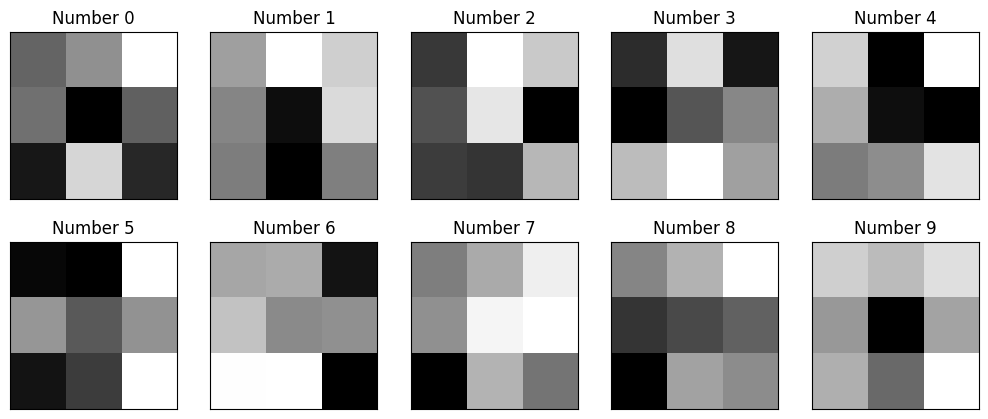

In [50]:
fig = plt.figure(figsize=[5*2.5, 2*2.5])
for i in range(10):                          # loops through first 10 filters,  Each filter corresponds to a learned weight matrix, which is applied to the input image.
  ax = fig.add_subplot(2, 5, i+1)
  # access the ith weight, reshapes to 3*3 matrix  
  ws = cnn_model.conv1.weight[i].reshape([3, 3]).cpu().detach().numpy() # Change here if your filter size is changed 
  ax.imshow(ws, cmap='gray')
  plt.title(f"Number {i}")
  plt.xticks([])
  plt.yticks([])

In [51]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks for all 3 convolutional layers
cnn_model.conv1.register_forward_hook(get_activation('conv1'))
cnn_model.conv2.register_forward_hook(get_activation('conv2'))
cnn_model.conv3.register_forward_hook(get_activation('conv3'))
cnn_model.conv4.register_forward_hook(get_activation('conv4'))


In [52]:
data, _ = test_ds[0]        # get single sample
# Remove all singleton dimensions except the last two (H, W)
data = data.squeeze()        # shape: [28, 28]
data = data.unsqueeze(0)     # add channel dimension -> [1, 28, 28]
data = data.unsqueeze(0)     # add batch dimension -> [1, 1, 28, 28]

print(data.shape)            # Should now be [1, 1, 28, 28]
data = data.to(device)
output = cnn_model(data)

torch.Size([1, 1, 28, 28])


In [53]:
def plot_feature_maps(feature_map, num_cols=6, title="Feature maps"):
    feature_map = feature_map.squeeze().cpu().numpy()  # remove batch dimension
    
    num_kernels = feature_map.shape[0]
    num_rows = int(np.ceil(num_kernels / num_cols))

    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    plt.suptitle(title, fontsize=16)

    for i in range(num_kernels):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        ax.imshow(feature_map[i], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [54]:
activation['conv2'].shape, activation['conv4'].shape

(torch.Size([1, 32, 11, 11]), torch.Size([1, 128, 5, 5]))

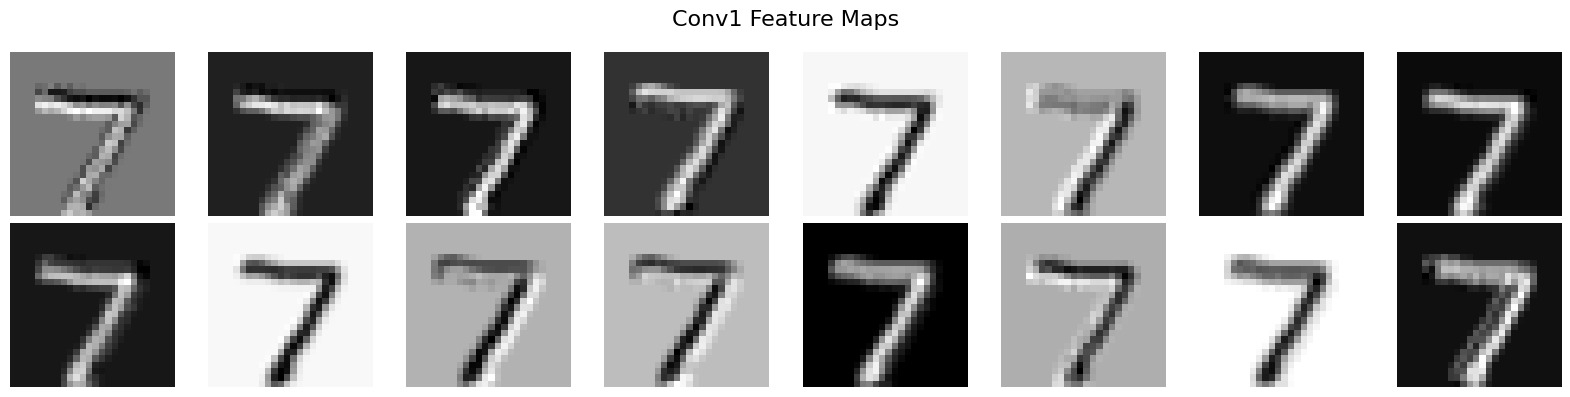

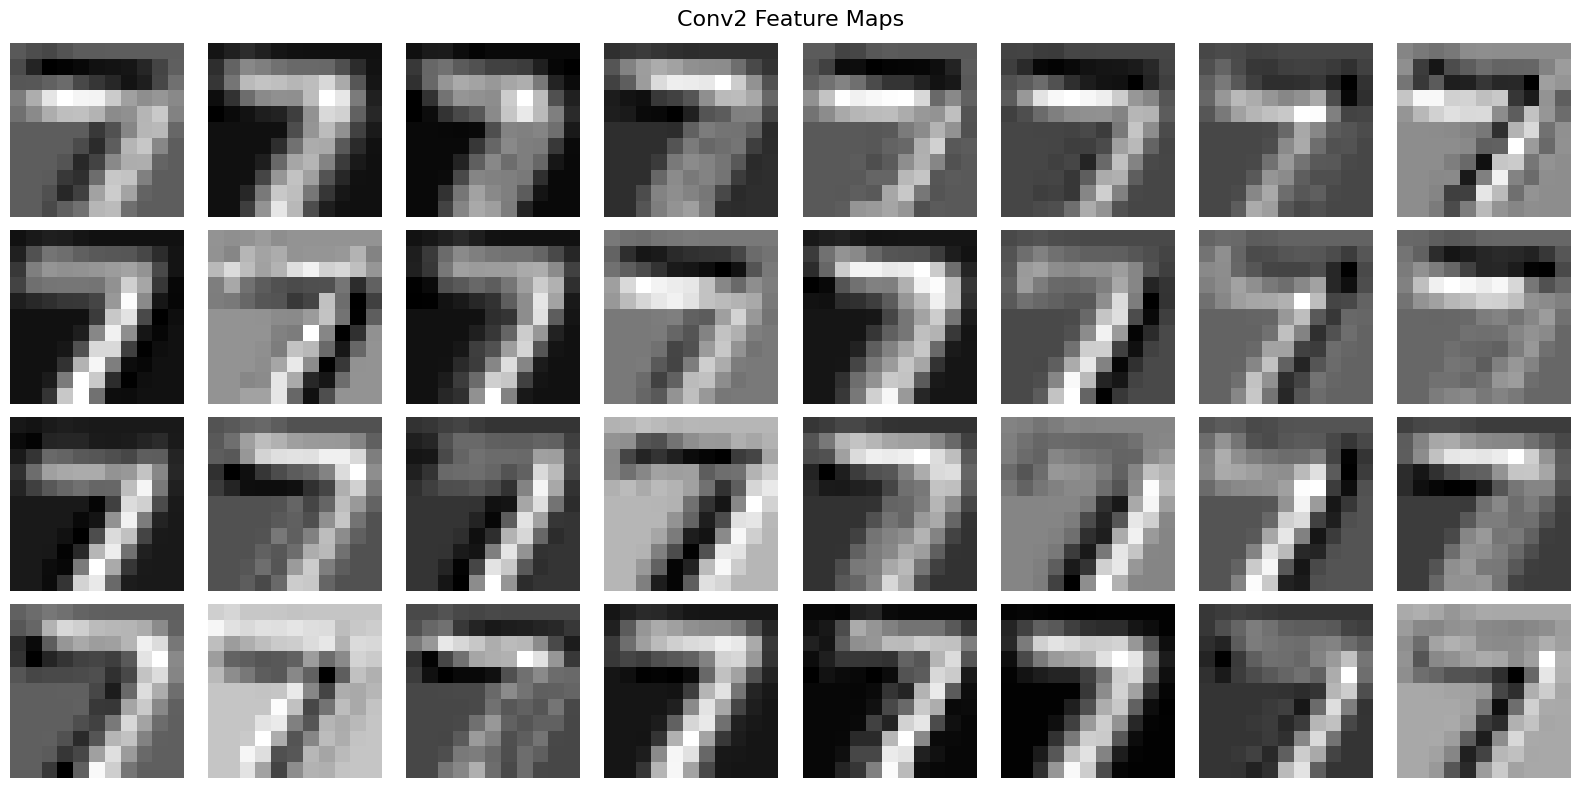

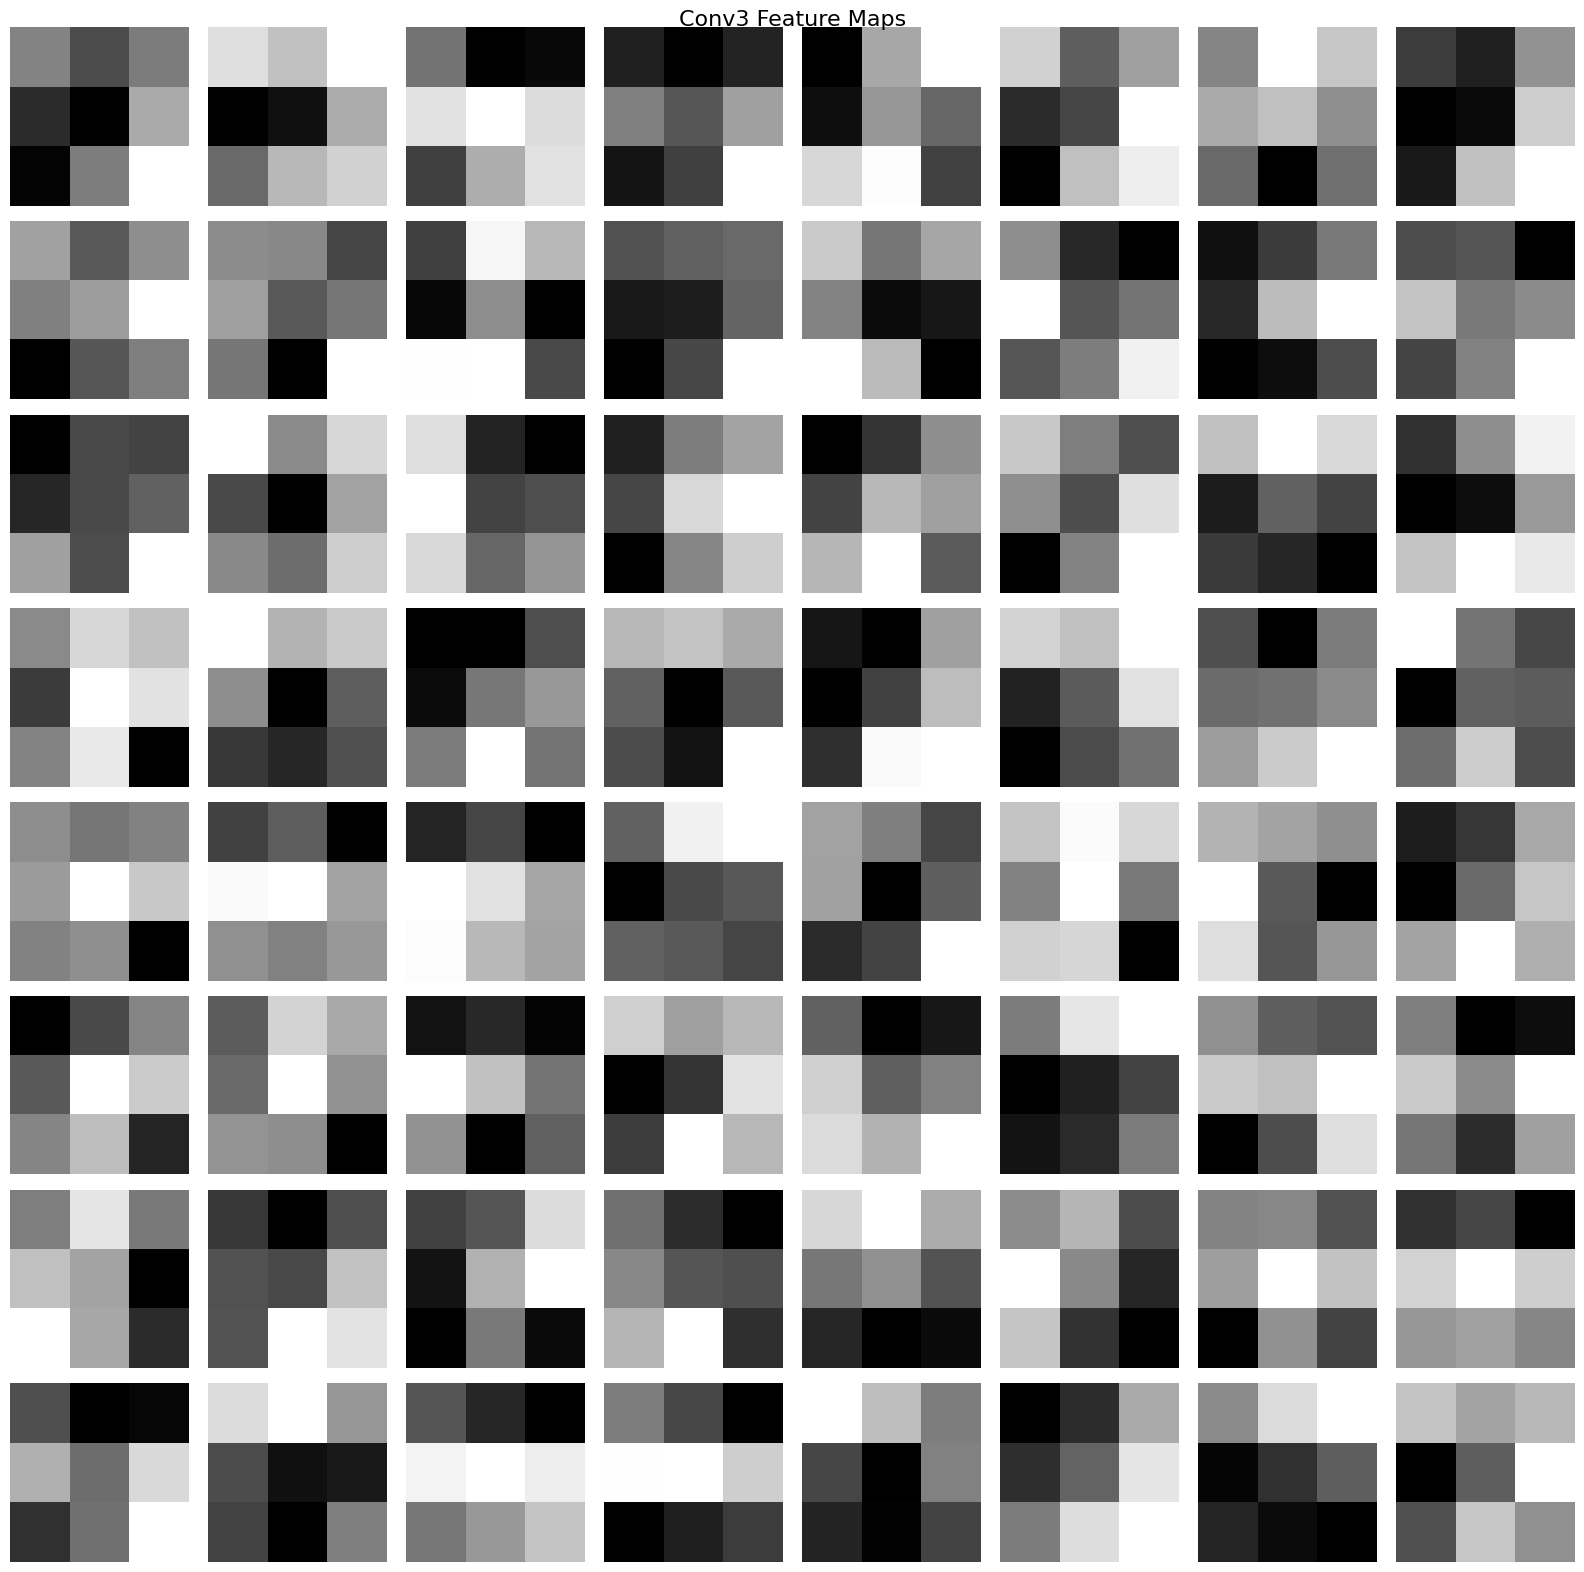

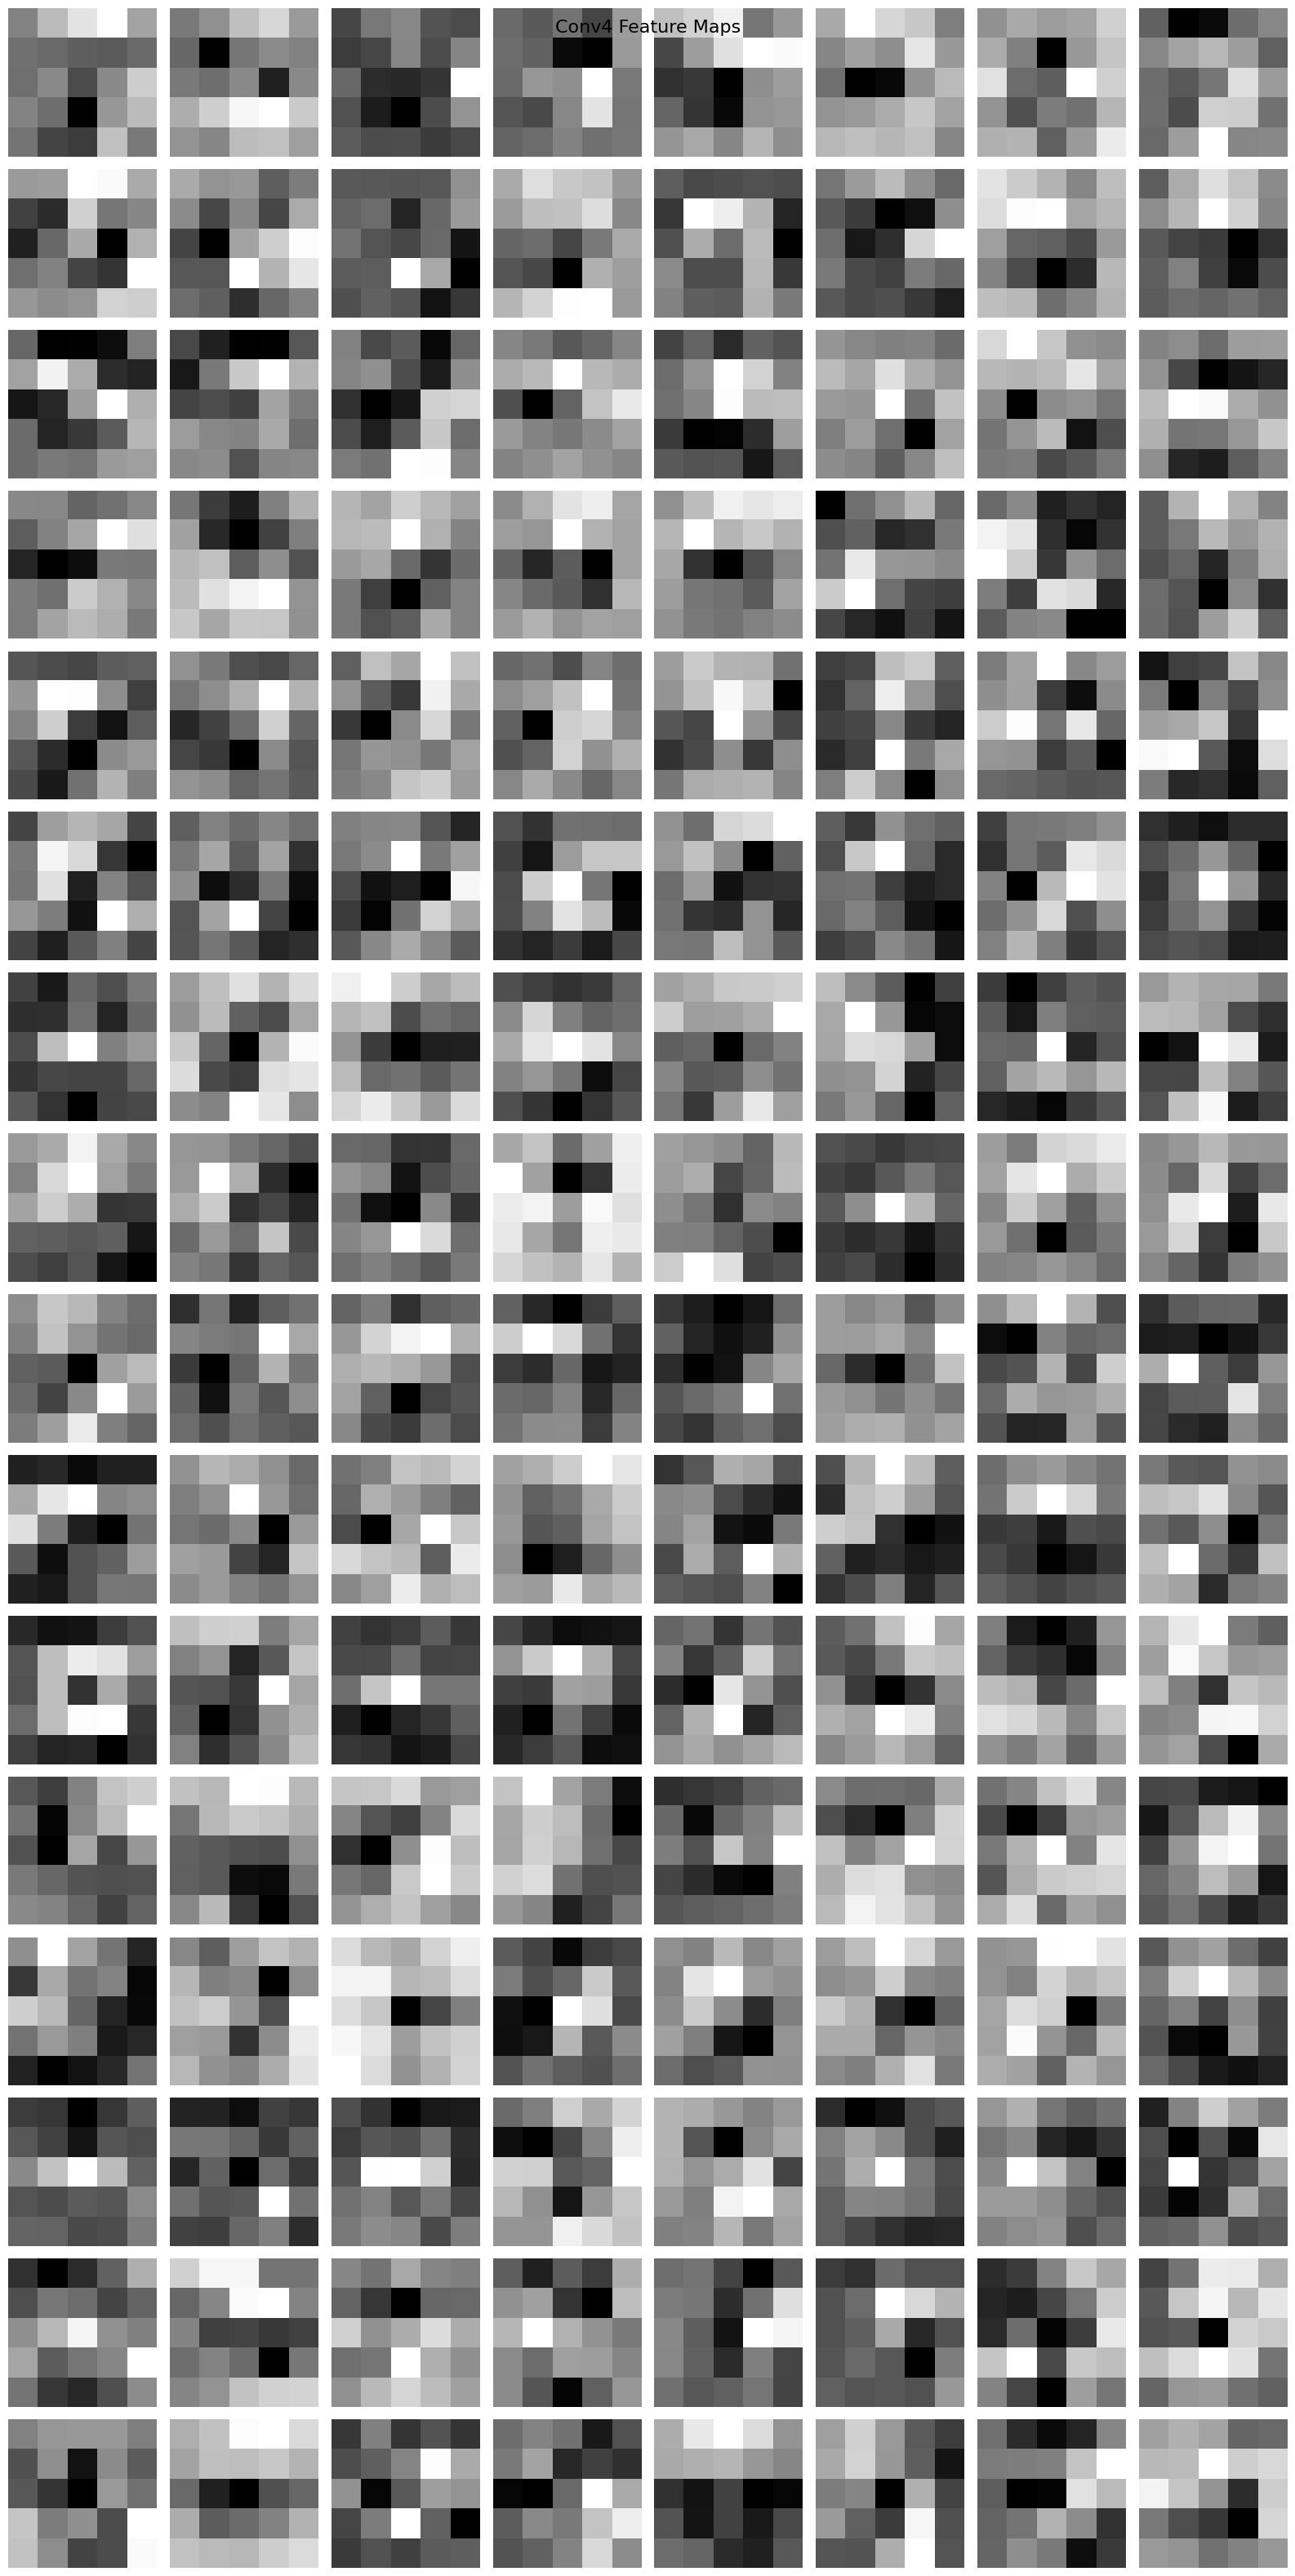

In [56]:
plot_feature_maps(activation['conv1'], num_cols=8, title="Conv1 Feature Maps")
plot_feature_maps(activation['conv2'], num_cols=8, title="Conv2 Feature Maps")
plot_feature_maps(activation['conv3'], num_cols=8, title="Conv3 Feature Maps")
plot_feature_maps(activation['conv4'], num_cols=8, title="Conv4 Feature Maps")